In [1]:
import random

import dalex as dx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn import model_selection, ensemble, metrics
import lime
import lime.lime_tabular

sns.set_theme()

C:\Users\alan\anaconda3\envs\xai\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
def seed_everything(seed: int) -> int:
    random.seed(seed)
    np.random.seed(seed)

    return seed

In [3]:
SEED = 357
seed_everything(SEED)

357

In [4]:
data = pd.read_csv('../data/raw/temat_2_dane.csv')
data_cols_description = pd.read_excel('../data/raw/temat_2_opis_zmiennych.xlsx')

In [5]:
def train_test_split_by_income(data, test_size=0.2, bins=5):
    income_bined = pd.qcut(data['Y'], q=bins)

    return model_selection.train_test_split(data, test_size=test_size, shuffle=True, stratify=income_bined, random_state=SEED)

In [6]:
data_train_val, data_test = train_test_split_by_income(data)
data_train, data_val = train_test_split_by_income(data_train_val, test_size=0.25)

In [7]:
X_train, y_train = data_train.drop('Y', axis=1), data_train['Y']
X_val, y_val = data_val.drop('Y', axis=1), data_val['Y']

vars = ['X1'] + [f'X{j}' for j in range(4, 295 + 1, 7)]

X_train = X_train[vars]
X_val = X_val[vars]

for dataset in [X_train, y_train, X_val, y_val]:
    dataset.reset_index(drop=True, inplace=True)

In [8]:
xgb_best_params = {"max_depth": 23, "min_child_weight": 2.404712074481848, "colsample_bytree": 0.5095502611913834, "learning_rate": 0.0449682801162507, "subsample": 0.9196040393707718, "alpha": 0.0524693644585006, "lambda": 4.5586068865713215e-07}

In [9]:
model_xgb = xgb.XGBRegressor(verbosity=0, objective='reg:squarederror', n_estimators=10000, **xgb_best_params)
model_xgb.fit(X_train, np.log10(y_train + 1), eval_set=[(X_val, np.log10(y_val + 1))], eval_metric='mae', early_stopping_rounds=50)

[0]	validation_0-mae:3.18179
[1]	validation_0-mae:3.03884
[2]	validation_0-mae:2.90258
[3]	validation_0-mae:2.77239
[4]	validation_0-mae:2.64807
[5]	validation_0-mae:2.52938
[6]	validation_0-mae:2.41566
[7]	validation_0-mae:2.30735
[8]	validation_0-mae:2.20395
[9]	validation_0-mae:2.10496
[10]	validation_0-mae:2.01095
[11]	validation_0-mae:1.92068
[12]	validation_0-mae:1.83484
[13]	validation_0-mae:1.75282
[14]	validation_0-mae:1.67447
[15]	validation_0-mae:1.59968
[16]	validation_0-mae:1.52821
[17]	validation_0-mae:1.45987


C:\Users\alan\anaconda3\envs\xai\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18]	validation_0-mae:1.39451
[19]	validation_0-mae:1.33203
[20]	validation_0-mae:1.27228
[21]	validation_0-mae:1.21519
[22]	validation_0-mae:1.16107
[23]	validation_0-mae:1.10931
[24]	validation_0-mae:1.05995
[25]	validation_0-mae:1.01272
[26]	validation_0-mae:0.96783
[27]	validation_0-mae:0.92469
[28]	validation_0-mae:0.88369
[29]	validation_0-mae:0.84456
[30]	validation_0-mae:0.80725
[31]	validation_0-mae:0.77164
[32]	validation_0-mae:0.73740
[33]	validation_0-mae:0.70484
[34]	validation_0-mae:0.67406
[35]	validation_0-mae:0.64475
[36]	validation_0-mae:0.61699
[37]	validation_0-mae:0.59049
[38]	validation_0-mae:0.56531
[39]	validation_0-mae:0.54131
[40]	validation_0-mae:0.51857
[41]	validation_0-mae:0.49681
[42]	validation_0-mae:0.47631
[43]	validation_0-mae:0.45687
[44]	validation_0-mae:0.43872
[45]	validation_0-mae:0.42125
[46]	validation_0-mae:0.40489
[47]	validation_0-mae:0.38979
[48]	validation_0-mae:0.37536
[49]	validation_0-mae:0.36172
[50]	validation_0-mae:0.34874
[51]	valid

XGBRegressor(alpha=0.0524693644585006, base_score=0.5, booster='gbtree',
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.5095502611913834, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', lambda=4.5586068865713215e-07,
             learning_rate=0.0449682801162507, max_delta_step=0, max_depth=23,
             min_child_weight=2.404712074481848, missing=nan,
             monotone_constraints='()', n_estimators=10000, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.0524693653, reg_lambda=4.55860715e-07,
             scale_pos_weight=1, subsample=0.9196040393707718,
             tree_method='exact', validate_parameters=1, verbosity=0)

In [10]:
print(metrics.mean_absolute_error(y_val, 10**model_xgb.predict(X_val) - 1))

4614.77371751709


In [11]:
random_observations = data_val.sample(3, random_state=32)
X_random_observations = random_observations.drop('Y', axis=1)[vars]
y_random_observations = random_observations['Y']

In [12]:
10**model_xgb.predict(X_random_observations)-1

array([ 7309.2163,  6252.5635, 23410.467 ], dtype=float32)

In [13]:
y_random_observations

5020     3203.00
4667     6427.77
7936    22723.00
Name: Y, dtype: float64

In [14]:
feature_names = data_cols_description[data_cols_description['NAZWA'].isin(vars)]['OPIS']

In [15]:
xgb_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.to_numpy(),
    feature_names=feature_names,
    verbose=True,
    mode='regression'
)

In [16]:
xgb_predict = lambda x: 10 ** model_xgb.predict(x) - 1

In [63]:
def as_pyplot_figure(self, label=1, **kwargs):
    """Returns the explanation as a pyplot figure.

    Will throw an error if you don't have matplotlib installed
    Args:
        label: desired label. If you ask for a label for which an
               explanation wasn't computed, will throw an exception.
               Will be ignored for regression explanations.
        kwargs: keyword arguments, passed to domain_mapper

    Returns:
        pyplot figure (barchart).
    """
    import matplotlib.pyplot as plt
    exp = self.as_list(label=label, **kwargs)
    fig = plt.figure(figsize=(16.9, 4.6), dpi=200)
    vals = [x[1] for x in exp]
    names = [x[0] for x in exp]
    vals.reverse()
    names.reverse()
    colors = ['green' if x > 0 else 'red' for x in vals]
    pos = np.arange(len(exp)) + .5
    plt.barh(pos, vals, align='center', color=colors)
    plt.yticks(pos, names)
    if self.mode == "classification":
        title = 'Local explanation for class %s' % self.class_names[label]
    else:
        title = f'Local explanation (intercept: {self.intercept[0]:.2f}, local pred: {self.local_pred[0]:.2f}, global pred: {self.predicted_value:.2f})'
    plt.title(title)
    plt.tight_layout()
    return fig

In [18]:
NUM_FEATURES = 5

Intercept 9365.253680057822
Prediction_local [7136.71884273]
Right: 7309.2163


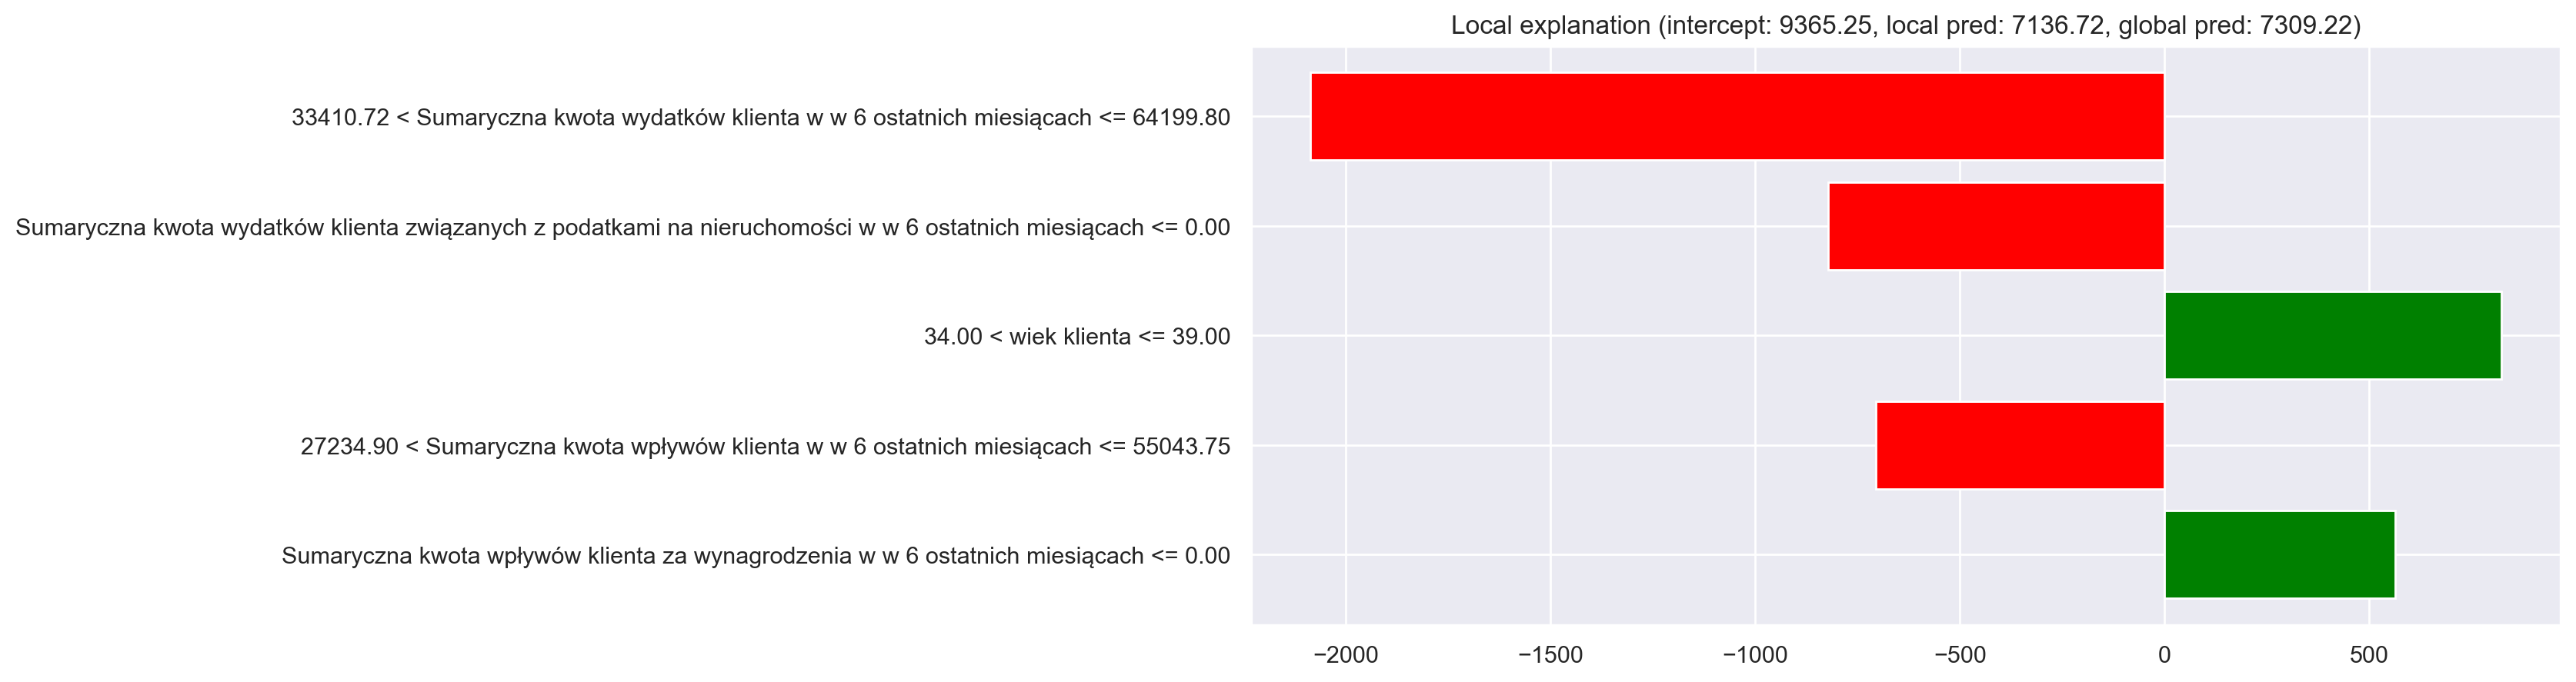

In [19]:
xgb_exp = xgb_explainer.explain_instance(X_random_observations.to_numpy()[0].flatten(), xgb_predict, num_features=NUM_FEATURES)

fig = as_pyplot_figure(xgb_exp)
fig.savefig(f'../reports/figures/xgb_sample=0_num-features={NUM_FEATURES}.png')

Intercept 9857.167346416694
Prediction_local [3889.76363989]
Right: 6252.5635


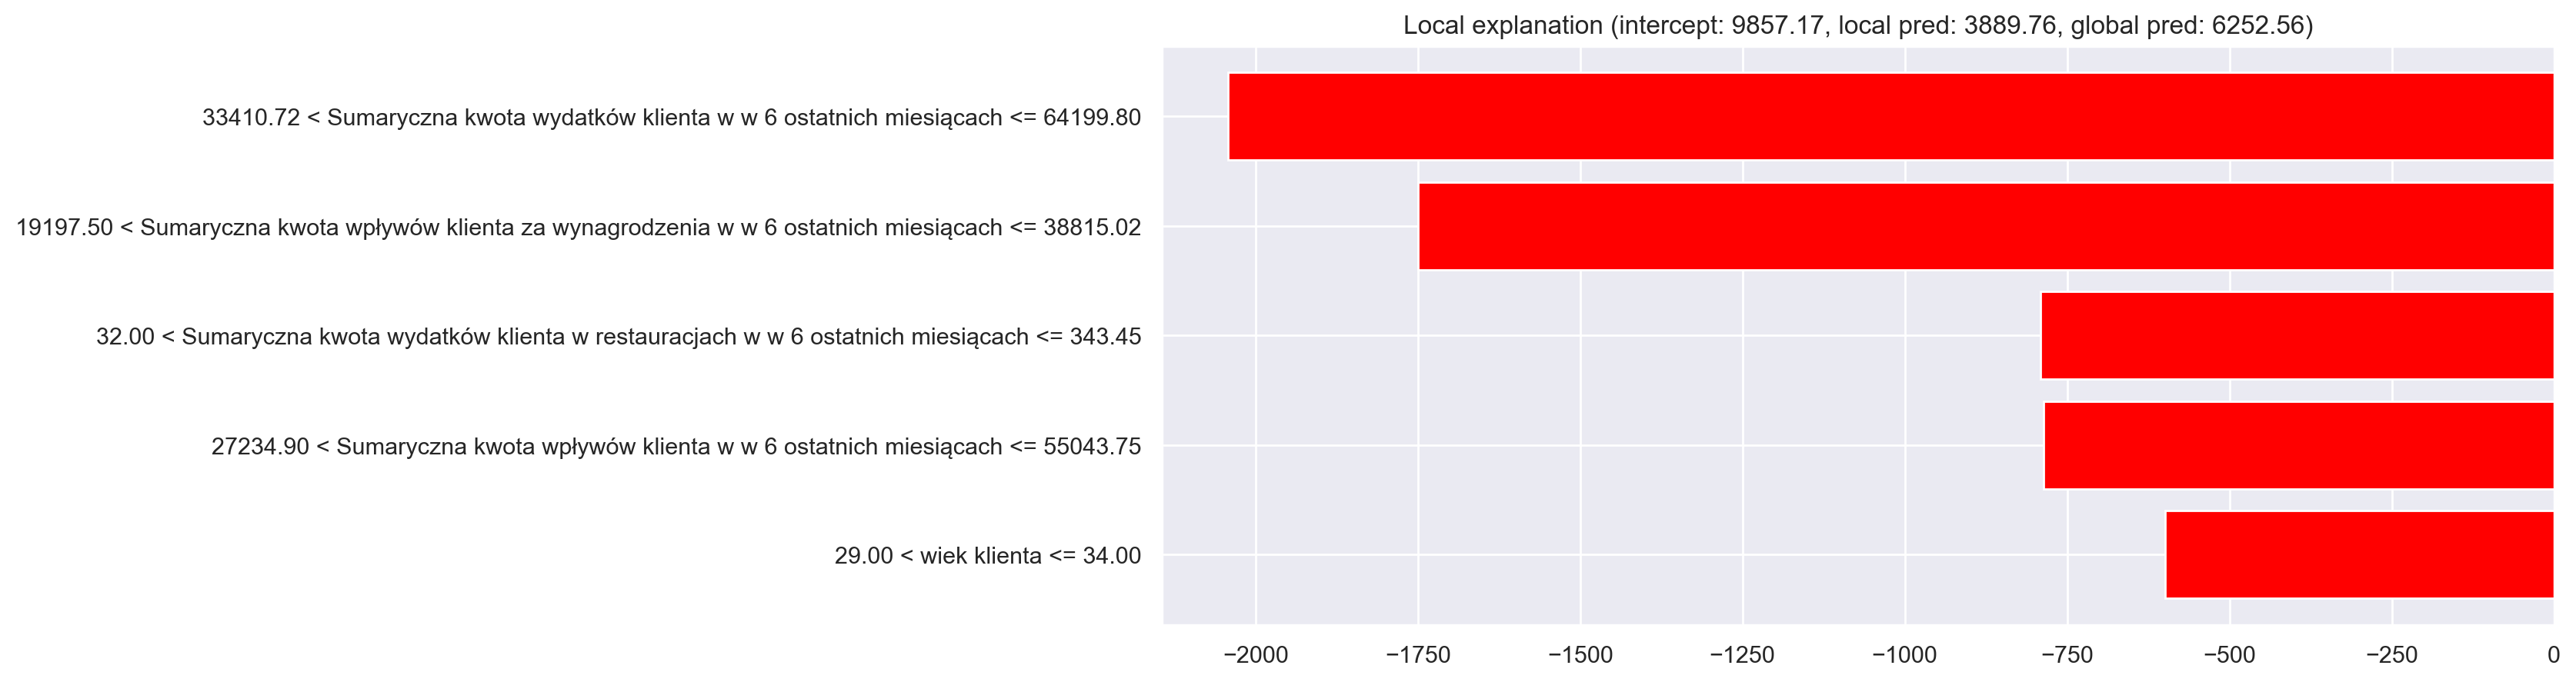

In [20]:
xgb_exp = xgb_explainer.explain_instance(X_random_observations.to_numpy()[1].flatten(), xgb_predict, num_features=NUM_FEATURES)

fig = as_pyplot_figure(xgb_exp)
fig.savefig(f'../reports/figures/xgb_sample=1_num-features={NUM_FEATURES}.png')

Intercept 6130.175959229857
Prediction_local [15234.80568457]
Right: 23410.467


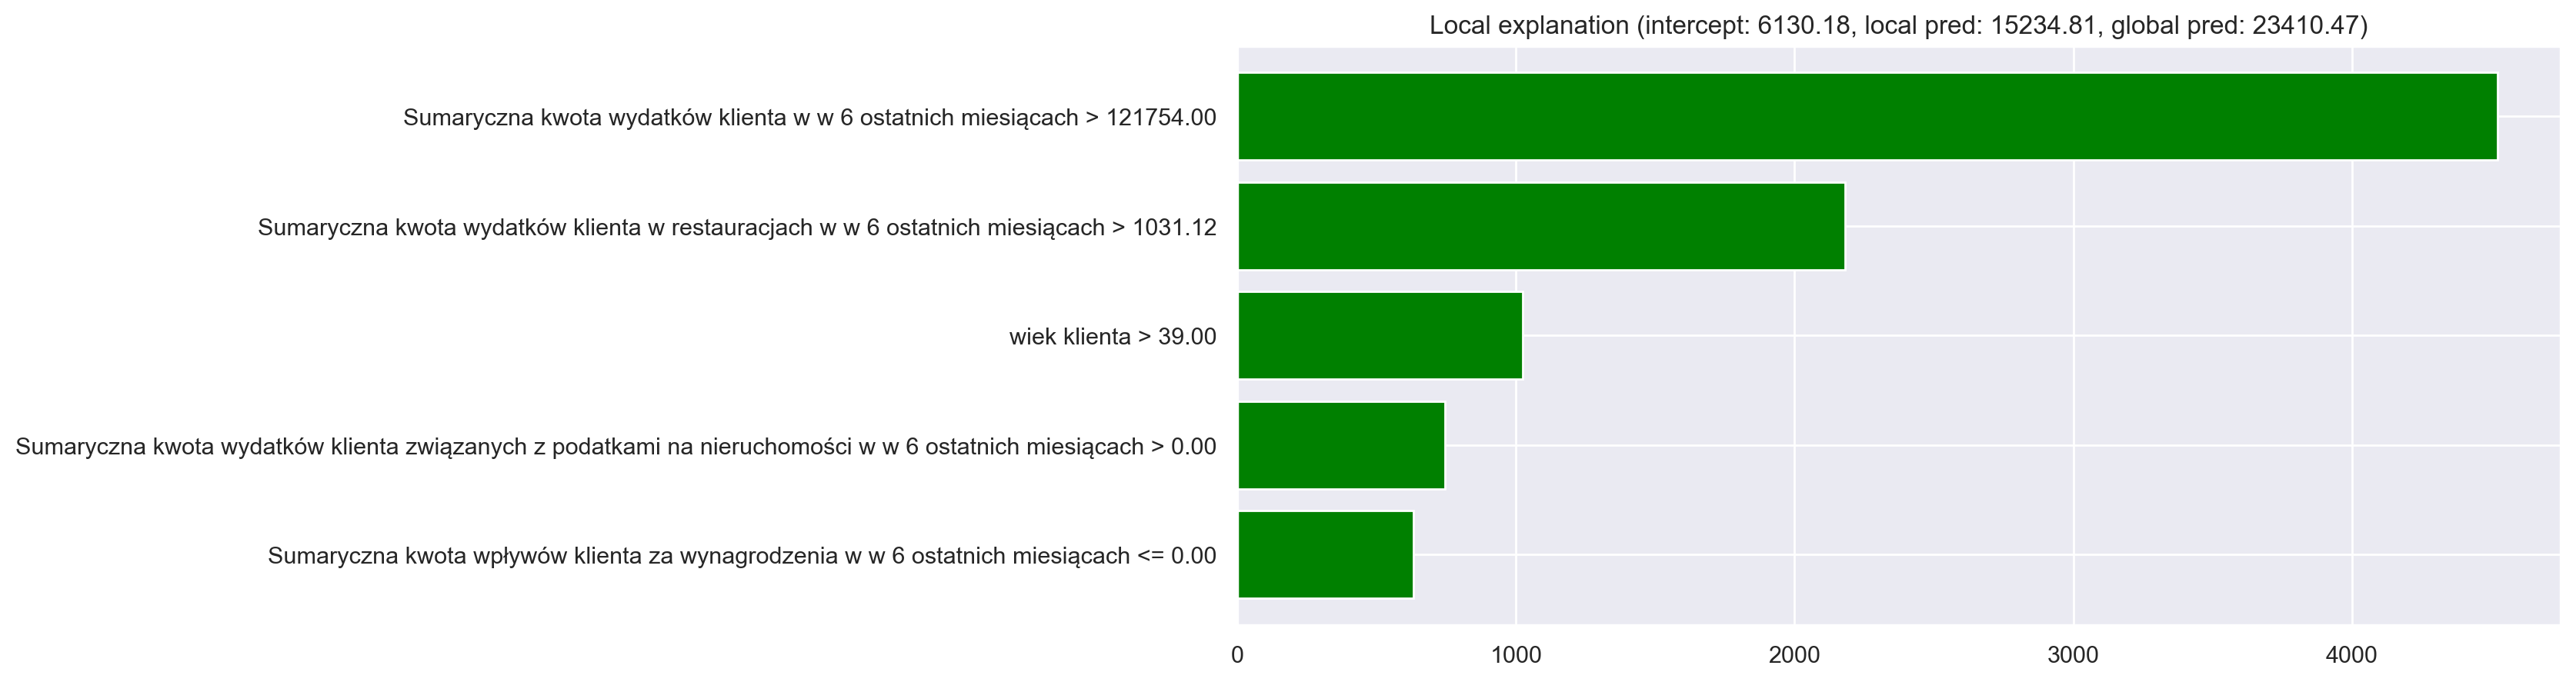

In [21]:
xgb_exp = xgb_explainer.explain_instance(X_random_observations.to_numpy()[2].flatten(), xgb_predict, num_features=NUM_FEATURES)

fig = as_pyplot_figure(xgb_exp)
fig.savefig(f'../reports/figures/xgb_sample=2_num-features={NUM_FEATURES}.png')

In [22]:
rf_best_params = {"n_estimators": 750, "max_features": 0.2969145621920279}
rf_model = ensemble.RandomForestRegressor(**rf_best_params)
rf_model.fit(X_train, np.log10(y_train + 1))

RandomForestRegressor(max_features=0.2969145621920279, n_estimators=750)

In [23]:
rf_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.to_numpy(),
    feature_names=feature_names,
    verbose=True,
    mode='regression'
)

rf_predict = lambda x: 10 ** rf_model.predict(x) - 1

In [54]:
NUM_FEATURES = 5
for sample in X_val.to_numpy():
    xgb_exp = xgb_explainer.explain_instance(sample, xgb_predict, num_features=NUM_FEATURES)
    rf_exp = rf_explainer.explain_instance(sample, rf_predict, num_features=NUM_FEATURES)

    xgb_exp_vars = set([var[0] for var in xgb_exp.as_list()])
    rf_exp_vars = set([var[0] for var in rf_exp.as_list()])

    print(len(xgb_exp_vars & rf_exp_vars))
    if len(xgb_exp_vars & rf_exp_vars) <= 3:
        break


Intercept 9955.790302161351
Prediction_local [3378.12602077]
Right: 4985.511


C:\Users\alan\anaconda3\envs\xai\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Intercept 9475.791491187481
Prediction_local [4678.5640627]
Right: 4836.988357511261
4
Intercept 8063.97944050288
Prediction_local [10585.05309179]
Right: 6687.5234


C:\Users\alan\anaconda3\envs\xai\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Intercept 7357.249676980299
Prediction_local [11166.31458474]
Right: 7433.236435838916
3


In [59]:
xgb_exp.local_pred

array([10585.05309179])

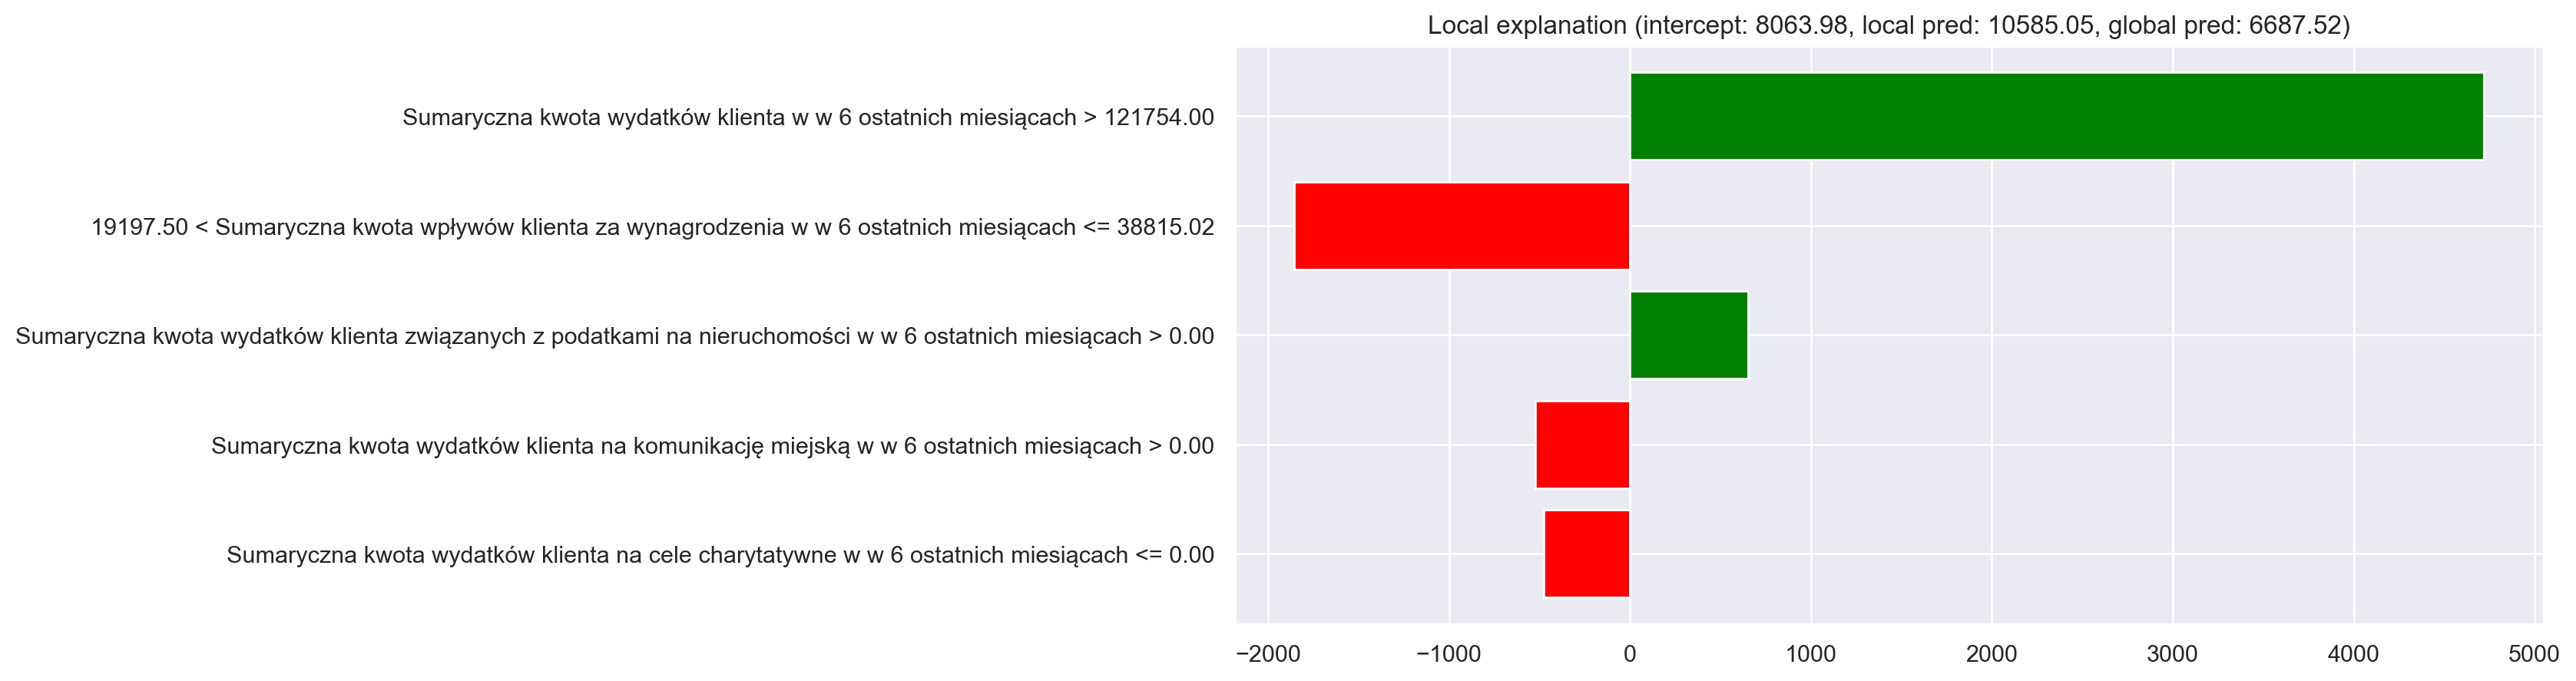

In [64]:
fig = as_pyplot_figure(xgb_exp)
fig.savefig(f'../reports/figures/xgb_sample_num-features={NUM_FEATURES}.png')

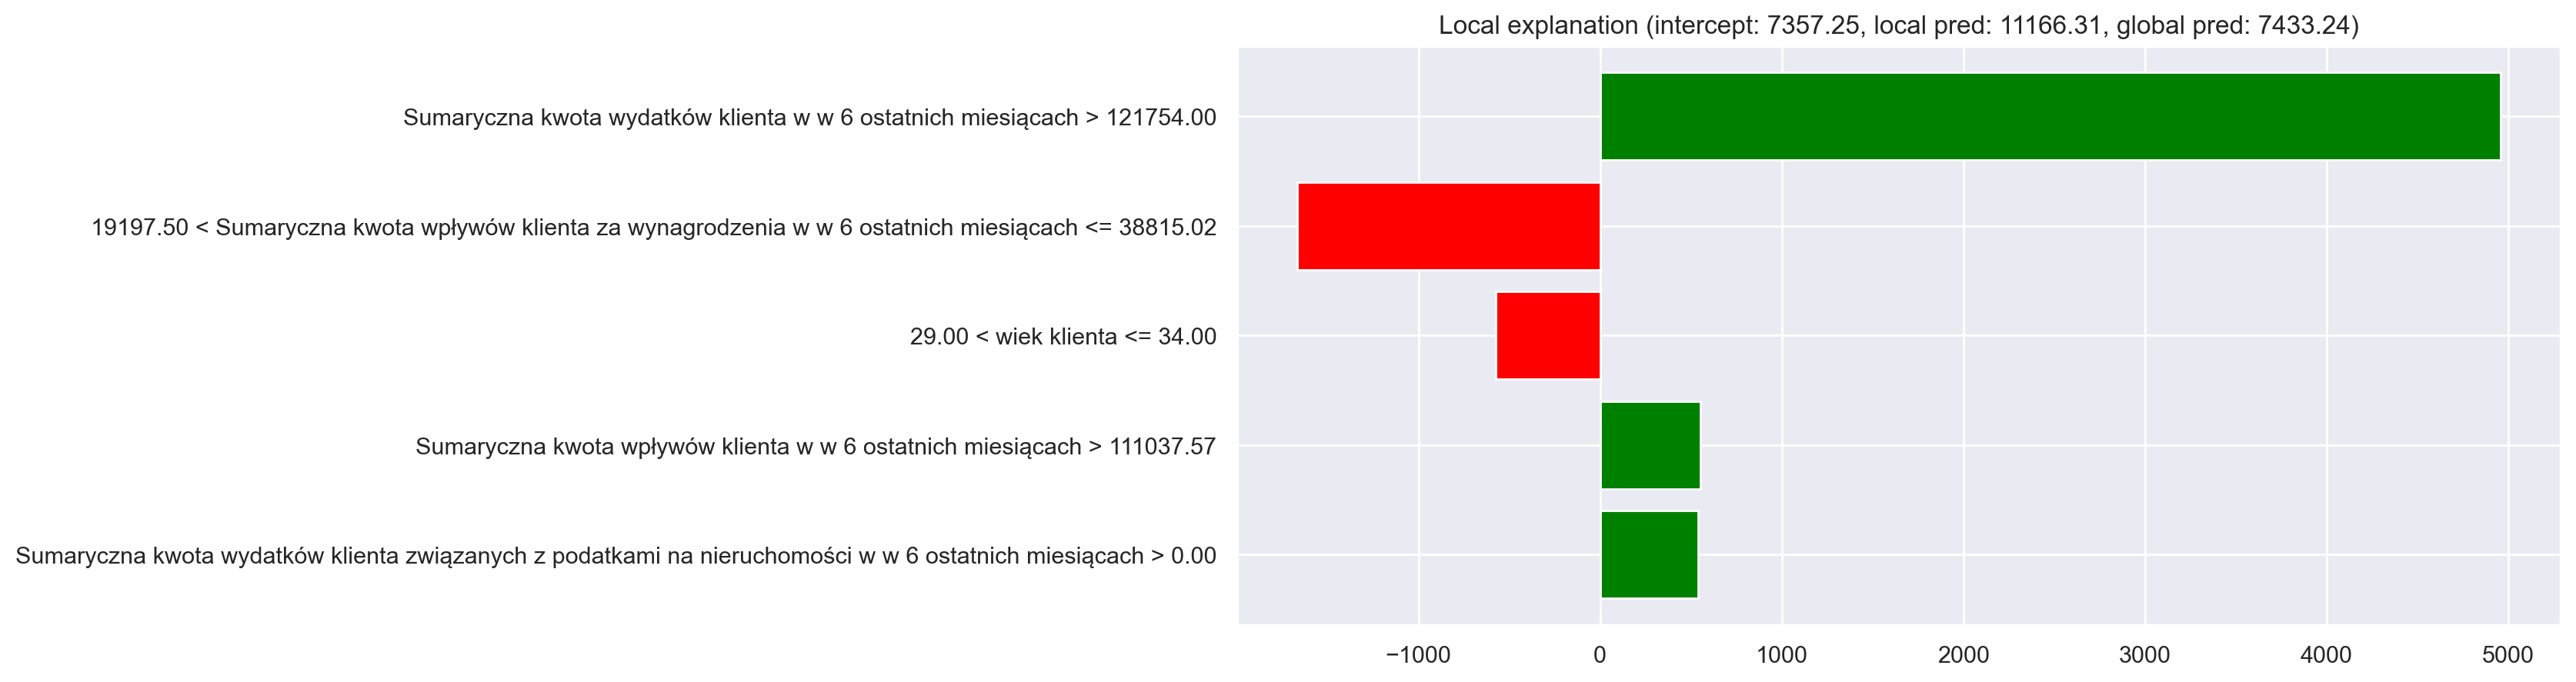

In [65]:
fig = as_pyplot_figure(rf_exp)
fig.savefig(f'../reports/figures/rf_sample_num-features={NUM_FEATURES}.png')